# This notebook creates Figure 3

In [1]:
import xarray as xr
import numpy as np
import xcdat as xc
import xskillscore as xscore
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
# import cmocean as cmo
from scipy.stats import linregress
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from typing import Tuple, List

from matplotlib.gridspec import GridSpec

In [2]:
def get_triangle(tos, latmin: float = -38.75, latmax: float = -1.25, lonmin: float = -178.75, lonmax: float = -71.25, RES: float = 2.5):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    # print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
    nmodel, _, nlon, ntime = ctos.shape
    # print(ctos)

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == nlon: break

        # print("j prior: ", j)
        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
             
        # print("j: ", j)
        nlats = int(len(latcoords) - j) # nlats below diag
        # print("nlats: ", nlats)
        ctos[:,:nlats,i,:] = np.full((nmodel, nlats,ntime), np.nan) 
        
        jold = j
    
    return ctos

In [3]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

SEB_CMIP6 = xr.open_dataset("data/piControl/SEB_CMIP6_full.nc")*3
SEB_CMIP5 = xr.open_dataset("data/piControl/SEB_CMIP5_full.nc")*3
SEB_CMIP6["NON_CLOUD"] = SEB_CMIP6["SW_Other"] - SEB_CMIP6["LW_Other"]
SEB_CMIP5["NON_CLOUD"] = SEB_CMIP5["SW_Other"] - SEB_CMIP5["LW_Other"]
shared_models_cmip6 = SEB_CMIP6.model.values
shared_models_cmip5 = SEB_CMIP5.model.values
print(SEB_CMIP6)

ERA = "CMIP6"
U10_CMIP6 = xr.open_dataarray(f"data/piControl/rolling_gradient_U10_{ERA}.nc")*3
V10_CMIP6 = xr.open_dataarray(f"data/piControl/rolling_gradient_V10_{ERA}.nc")*3
 
U10_CMIP6 = fix_coords(U10_CMIP6.rename("U10").to_dataset())
V10_CMIP6 = fix_coords(V10_CMIP6.rename("V10").to_dataset())
print(V10_CMIP6)

<xarray.Dataset>
Dimensions:    (model: 35, lat: 72, lon: 144, time: 120, bnds: 2)
Coordinates:
  * model      (model) object 'GISS-E2-1-G' 'EC-Earth3-LR' ... 'CMCC-CM2-SR5'
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118 119
Dimensions without coordinates: bnds
Data variables: (12/20)
    NET        (model, time, lat, lon) float64 nan nan nan ... 2.843 2.852 2.845
    O          (model, time, lat, lon) float64 nan nan nan ... 0.6065 0.2702
    W          (model, time, lat, lon) float64 nan nan nan ... 0.008707 0.01837
    RH         (model, time, lat, lon) float64 nan nan ... -0.0002415 -0.0002398
    DT         (model, time, lat, lon) float64 nan nan nan ... 0.8565 0.8549
    LH_Other   (model, time, lat, lon) float64 nan nan nan ... 0.865 0.8731
    ...         ...
    SW_Other   (model, time, lat, l

In [4]:
# Load Rolling Gradient for Regions TOS CMIP6
SST_T_EPSA_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificSA_trend.nc").sel(model=shared_models_cmip6)
SST_T_WE_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_WE-Trend.nc").sel(model=shared_models_cmip6)
SST_T_E_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacific_trend.nc").sel(model=shared_models_cmip6)
SST_T_SO_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_southernOcean_trend.nc").sel(model=shared_models_cmip6)
SST_T_EPT_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc").sel(model=shared_models_cmip6)

# Load Rolling Gradient for Regions TOS CMIP5
SST_T_EPSA_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificSA_trend.nc").sel(model=shared_models_cmip5)
SST_T_WE_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_WE-Trend.nc").sel(model=shared_models_cmip5)
SST_T_E_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacific_trend.nc").sel(model=shared_models_cmip5)
SST_T_SO_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_southernOcean_trend.nc").sel(model=shared_models_cmip5)
SST_T_EPT_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc").sel(model=shared_models_cmip5)

In [5]:
def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)
    
SWCF_CMIP6 = xr.open_dataarray("data/piControl/swcf_east_sa_cmip6_v3.nc")
SWCF_CMIP5 = xr.open_dataarray("data/piControl/swcf_east_sa_cmip5_v3.nc")

SWCF_CMIP6, SEB_CMIP6 = get_shared_models(SWCF_CMIP6, SEB_CMIP6)
SWCF_CMIP5, SEB_CMIP5 = get_shared_models(SWCF_CMIP5, SEB_CMIP5)

In [6]:
SWCF_CMIP6

<xarray.DataArray 'swcf' (model: 34)>
[34 values with dtype=float64]
Coordinates:
  * model    (model) object 'E3SM-1-0' 'CESM2' ... 'IPSL-CM6A-LR'

In [7]:
SEB_CMIP6

<xarray.Dataset>
Dimensions:    (model: 34, lat: 72, lon: 144, time: 120, bnds: 2)
Coordinates:
  * model      (model) object 'E3SM-1-0' 'CESM2' ... 'IPSL-CM6A-LR'
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118 119
Dimensions without coordinates: bnds
Data variables: (12/20)
    NET        (model, time, lat, lon) float64 nan nan nan ... 1.503 1.557 1.527
    O          (model, time, lat, lon) float64 nan nan nan ... -17.31 -17.05
    W          (model, time, lat, lon) float64 nan nan nan ... 0.6504 0.6673
    RH         (model, time, lat, lon) float64 nan nan ... -0.000623 -0.0006225
    DT         (model, time, lat, lon) float64 nan nan nan ... -0.3872 -0.4036
    LH_Other   (model, time, lat, lon) float64 nan nan nan ... 0.2626 0.2631
    ...         ...
    SW_Other   (model, time, lat, lon) float64 nan nan nan ... 23.02 23.13 22.85
    EIS        (model, time, lat, lon) float64 0.0 0.0 0.0 ... 1.774 1.809 1.868
    lon_bnds   (lon, bnds) float64 -540.0 -532.5 -532.5 ... 532.5 532.5 -540.0
    lat_bnds   (lat, bnds) float64 -270.0 -262.5 -262.5 ... 262.5 262.5 270.0
    time_bnds  (time, bnds) float64 -1.5 1.5 1.5 4.5 ... 352.5 355.5 355.5 358.5
    NON_CLOUD  (model, time, lat, lon) float64 nan nan nan ... 11.85 11.45 10.51

In [8]:
def get_barplot_correlations(swcf_cmip: xr.Dataset,seb_cmip: xr.Dataset) -> List:
    """_summary_

    Args:
        seb_cmip (_type_): _description_
    Returns:
    """
    data_vars = list(SEB_CMIP6.data_vars.keys())
    data_vars = [i for i in data_vars if i not in ["lon_bnds", "lat_bnds", "time_bnds", "time", "lon", "lat"]]

    # Get NET SEB STD
    ept_net = get_triangle(seb_cmip["NET"])
    ept_net = fix_coords(ept_net.rename("NET").to_dataset()).spatial.average("NET")["NET"]
    ept_net = ept_net.std("time")

    data = {}
    p = {}
    for cvar in data_vars:
        ept_cvar = get_triangle(seb_cmip[cvar])
        ept_cvar = fix_coords(ept_cvar.rename(cvar).to_dataset()).spatial.average(cvar)[cvar]
        ept_cvar = ept_cvar.std("time")
        
        res_seb = linregress(ept_net.values, ept_cvar.values)
        res_swcf = linregress(swcf_cmip.values, ept_cvar.values)

        data[cvar] = [res_seb.rvalue, res_swcf.rvalue]
        p[cvar] = [res_seb.pvalue, res_swcf.pvalue]

    return data, p


corr_cmip6, p_cmip6 = get_barplot_correlations(SWCF_CMIP6, SEB_CMIP6)
corr_cmip5, p_cmip5 = get_barplot_correlations(SWCF_CMIP6, SEB_CMIP6)

corr_cmip, p_cmip = get_barplot_correlations(
    swcf_cmip=xr.concat([SWCF_CMIP6, SWCF_CMIP5], dim="model"), 
    seb_cmip=xr.concat([SEB_CMIP6, SEB_CMIP5], dim="model")
)
corr_cmip

{'NET': [1.0, 0.5530673552801803],
 'O': [0.38701990180230805, -0.1367714774877877],
 'W': [0.8047366911485594, 0.5797523689778519],
 'RH': [-0.2661834032477052, -0.19101415752921042],
 'DT': [0.44869192304526406, 0.09330033696881809],
 'LH_Other': [0.8221314821899056, 0.6212578496505557],
 'SH': [-0.07976408453991223, -0.24061175340554558],
 'SW': [0.2140354702275973, 0.14088193926986994],
 'LW': [0.2536800352165422, 0.2169133824319148],
 'SWC': [0.2771087064482165, 0.3354719165594083],
 'LWC': [0.3683840594900439, 0.5215430997209196],
 'TOS': [0.7589300350592614, 0.6953613755670891],
 'CLOUD': [0.04218535427618383, -0.11016845810936421],
 'LW_Other': [0.2550065820421003, 0.2452946219299984],
 'SW_Other': [0.6626661450848654, 0.4082839049116398],
 'EIS': [0.7179670188467787, 0.7123173020480079],
 'NON_CLOUD': [0.47067642087509465, 0.3871810143392051]}

In [9]:
SEB_CMIP6, SST_T_EPT_CMIP6 = get_shared_models(SEB_CMIP6, SST_T_EPT_CMIP6)
SEB_CMIP5, SST_T_EPT_CMIP5 = get_shared_models(SEB_CMIP5, SST_T_EPT_CMIP5)

U10_CMIP6, SEB_CMIP6 = get_shared_models(U10_CMIP6, SEB_CMIP6)
V10_CMIP6, SEB_CMIP6 = get_shared_models(V10_CMIP6, SEB_CMIP6)

SWCF_CMIP6, SEB_CMIP6 = get_shared_models(SWCF_CMIP6, SEB_CMIP6)
SWCF_CMIP5, SEB_CMIP5 = get_shared_models(SWCF_CMIP5, SEB_CMIP5)

In [10]:
EPT = get_triangle(SEB_CMIP6["NET"])
SEB_CMIP6_EPT = fix_coords(EPT.rename("NET").to_dataset()).spatial.average("NET")["NET"]
SEB_CMIP6_EPT, SST_T_EPT_CMIP6 = get_shared_models(SEB_CMIP6_EPT, SST_T_EPT_CMIP6)

# Prep Figure 4 Data

In [22]:
SEB_CMIP6_SO = SEB_CMIP6.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("NET")["NET"]
SO_Thres =  SEB_CMIP6_SO.mean("time") - SEB_CMIP6_SO.std("time")
SEB_SO_1sig = SEB_CMIP6.where(SEB_CMIP6_SO <= SO_Thres).mean(["time", "model"])
U10_SO_1sig = U10_CMIP6.where(SEB_CMIP6_SO <= SO_Thres).mean(["time", "model"])
V10_SO_1sig = V10_CMIP6.where(SEB_CMIP6_SO <= SO_Thres).mean(["time", "model"])

# Prep Figure S3 Data

In [11]:
EPT_Thres =  SEB_CMIP6_EPT.mean("time") - SEB_CMIP6_EPT.std("time")
SEB_CMIP6_1sig = SEB_CMIP6.where(SEB_CMIP6_EPT <= EPT_Thres).mean(["time", "model"])
U10_CMIP6_1sig = U10_CMIP6.where(SEB_CMIP6_EPT <= EPT_Thres).mean(["time", "model"])
V10_CMIP6_1sig = V10_CMIP6.where(SEB_CMIP6_EPT <= EPT_Thres).mean(["time", "model"])

# Prep Figure 3 Data

In [12]:
bottom_half_swcf = SWCF_CMIP6[SWCF_CMIP6 < SWCF_CMIP6.median()]
top_half_swcf =SWCF_CMIP6[SWCF_CMIP6 >= SWCF_CMIP6.median()]

# Select SST_T_EPT_CMIP6 models that are in the bottom half of SWCF_CMIP6 
# sstb = SST_T_EPT_CMIP6.sel(model=bottom_half_swcf.model)
sstb = SEB_CMIP6_EPT.sel(model=bottom_half_swcf.model)
sebb = SEB_CMIP6.sel(model=bottom_half_swcf.model)
u10b = U10_CMIP6.sel(model=bottom_half_swcf.model)
v10b = V10_CMIP6.sel(model=bottom_half_swcf.model)
threshold_b = -sstb.std("time")
sebb = sebb.where(sstb <= threshold_b)
u10b = u10b.where(sstb <= threshold_b)
v10b = v10b.where(sstb <= threshold_b) 

# sstt = SST_T_EPT_CMIP6.sel(model=top_half_swcf.model)
sstt = SEB_CMIP6_EPT.sel(model=top_half_swcf.model)
sebt = SEB_CMIP6.sel(model=top_half_swcf.model)
u10t = U10_CMIP6.sel(model=top_half_swcf.model)
v10t = V10_CMIP6.sel(model=top_half_swcf.model)
threshold_t = -sstt.std("time")
sebt = sebt.where(sstt <= threshold_t)
u10t = u10t.where(sstt <= threshold_t)
v10t = v10t.where(sstt <= threshold_t)

seb_dif = sebt.mean(["time", "model"]) - sebb.mean(["time", "model"])
v10_dif = v10t.mean(["time", "model"]) - v10b.mean(["time", "model"])
u10_dif = u10t.mean(["time", "model"]) - u10b.mean(["time", "model"])

# Figure 3, 3S, 4

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def global_plot(ax, data, lon, lat, cmap, pvalues=None, winds=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = ""):
    # plot map of global data with central longitude 180
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    if winds is not None: 
        # quiver([X, Y], U, V, [C], **kwargs)
        ax.quiver(lon[::3], lat[::3], winds["U10"][::3,::3], winds["V10"][::3,::3], scale=40, transform=ccrs.PlateCarree())

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -45, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    return img

In [18]:
def figure_3(seb_cmip6, u, v, corr_cmip, p_cmip, levels, save_name="Figure_3.png"):
    axis_fontsize = 12
    title_fontsize = 16
    
    fig = plt.figure(figsize=(24,18))
    gs = GridSpec(5, 2)
    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
    ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180))
    ax3 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree(central_longitude=180))
    ax4 = fig.add_subplot(gs[3], projection=ccrs.PlateCarree(central_longitude=180))
    ax5 = fig.add_subplot(gs[4], projection=ccrs.PlateCarree(central_longitude=180))
    ax6 = fig.add_subplot(gs[5], projection=ccrs.PlateCarree(central_longitude=180))
    ax7 = fig.add_subplot(gs[6], projection=ccrs.PlateCarree(central_longitude=180))
    ax8 = fig.add_subplot(gs[7], projection=ccrs.PlateCarree(central_longitude=180))
    ax9 = fig.add_subplot(gs[8])
    ax10 = fig.add_subplot(gs[9])
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, hspace=.25, wspace=0.10)
    
    cmap = "RdBu_r"

    # Plot Figure 3a: SST Trend
    global_plot(
        ax1,
        data=seb_cmip6["NET"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["NET"].median("model", skipna=True), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 3: Ocean
    img = global_plot(
        ax2,
        data=seb_cmip6["O"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["O"].median("model"), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 3: Latent Heat Trend
    global_plot(
        ax4,
        data=seb_cmip6["LH_Other"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["LH_Other"].median("model"), 
        winds={"U10": u["U10"].to_numpy(), "V10": v["V10"].to_numpy()},
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 3: Shortwave Cloud Trend
    global_plot(
        ax3,
        data=seb_cmip6["SWC"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["SWC"].median("model"), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 3: Sensible Heat Trend
    global_plot(
        ax6,
        data=seb_cmip6["SH"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["LWC"].median("model"), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 3: Longwave Cloud Trend
    global_plot(
        ax5,
        data=seb_cmip6["LWC"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["LWC"].median("model"), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    
    # Plot Figure 3: Cloud Trend
    global_plot(
        ax7,
        data=seb_cmip6["CLOUD"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["CLOUD"].median("model"), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 3: Radiation
    global_plot(
        ax8,
        data=seb_cmip6["NON_CLOUD"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["CLOUD"].median("model"), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    title_fontsize = 12
    ax1.set_title("NET", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax2.set_title("Ocean", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax3.set_title("SW Cloud", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax4.set_title("LH", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax5.set_title("LW Cloud", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax6.set_title("SH", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax7.set_title("Net Cloud", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax8.set_title("Non Cloud", loc="left", fontweight="bold", fontsize=title_fontsize)

    cbar = fig.colorbar(img, ax=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10], orientation='vertical', location="right", fraction=.1, pad=0.01)

    levels = [round(i, 3) for i in levels]
    cbar.set_ticks(ticks=levels, labels=levels)
    cbar.ax.set_title("K/30yr", fontsize=title_fontsize, fontweight="bold")
   
    names = list(corr_cmip.keys())
    swcf = [r**2 for _, r in corr_cmip.values()]
    seb = [r**2 for r, _ in corr_cmip.values()]
    p_swcf = [p for _, p in p_cmip.values()]
    p_seb = [p for p, _ in p_cmip.values()]

    h7 = ax9.bar(np.arange(len(names)), seb, color="black", alpha=.75)
    h8 = ax10.bar(np.arange(len(names)), swcf, color="black", alpha=.75)
    
    # Add labels ontop of bars 
    for i, (b7, b8) in enumerate(zip(h7, h8)):
        i7 = np.around(b7.get_height(), 2)
        i8 = np.around(b8.get_height(), 2)
        sig7, sig8 = '', ''
        if p_seb[i] <= 0.05: sig7 = "*"
        if p_swcf[i] <= 0.05: sig8 = "*"

        ax9.text(x=b7.get_x() + b7.get_width() / 2, y=i7+.05, s=f"{i7}{sig7}", ha='center', fontsize=title_fontsize)
        ax10.text(x=b8.get_x() + b8.get_width() / 2, y=i8+.05, s=f"{i8}{sig8}", ha='center', fontsize=title_fontsize)

    # Set title
    ax9.set_title(r"$R^2[\sigma(\Delta NET), \sigma(\Delta X)]$", loc="left", fontweight="bold", fontsize=title_fontsize) 
    ax10.set_title(r"$R^2[SWCF_{EPSA}, \sigma(\Delta X)]$", loc="left", fontweight="bold", fontsize=title_fontsize) 

    # Add xlabels
    ax9.set_xticks(np.arange(len(names)))
    ax9.set_xticklabels(names, fontsize=axis_fontsize)
    ax10.set_xticks(np.arange(len(names)))
    ax10.set_xticklabels(names, fontsize=axis_fontsize)

    ax9.set_ylim(0, 1)
    ax10.set_ylim(0, 1)
    ax9.grid(); ax10.grid()

    # Reduce White Space
    plt.savefig(save_name, dpi=1200, bbox_inches = 'tight')



## Figure 3

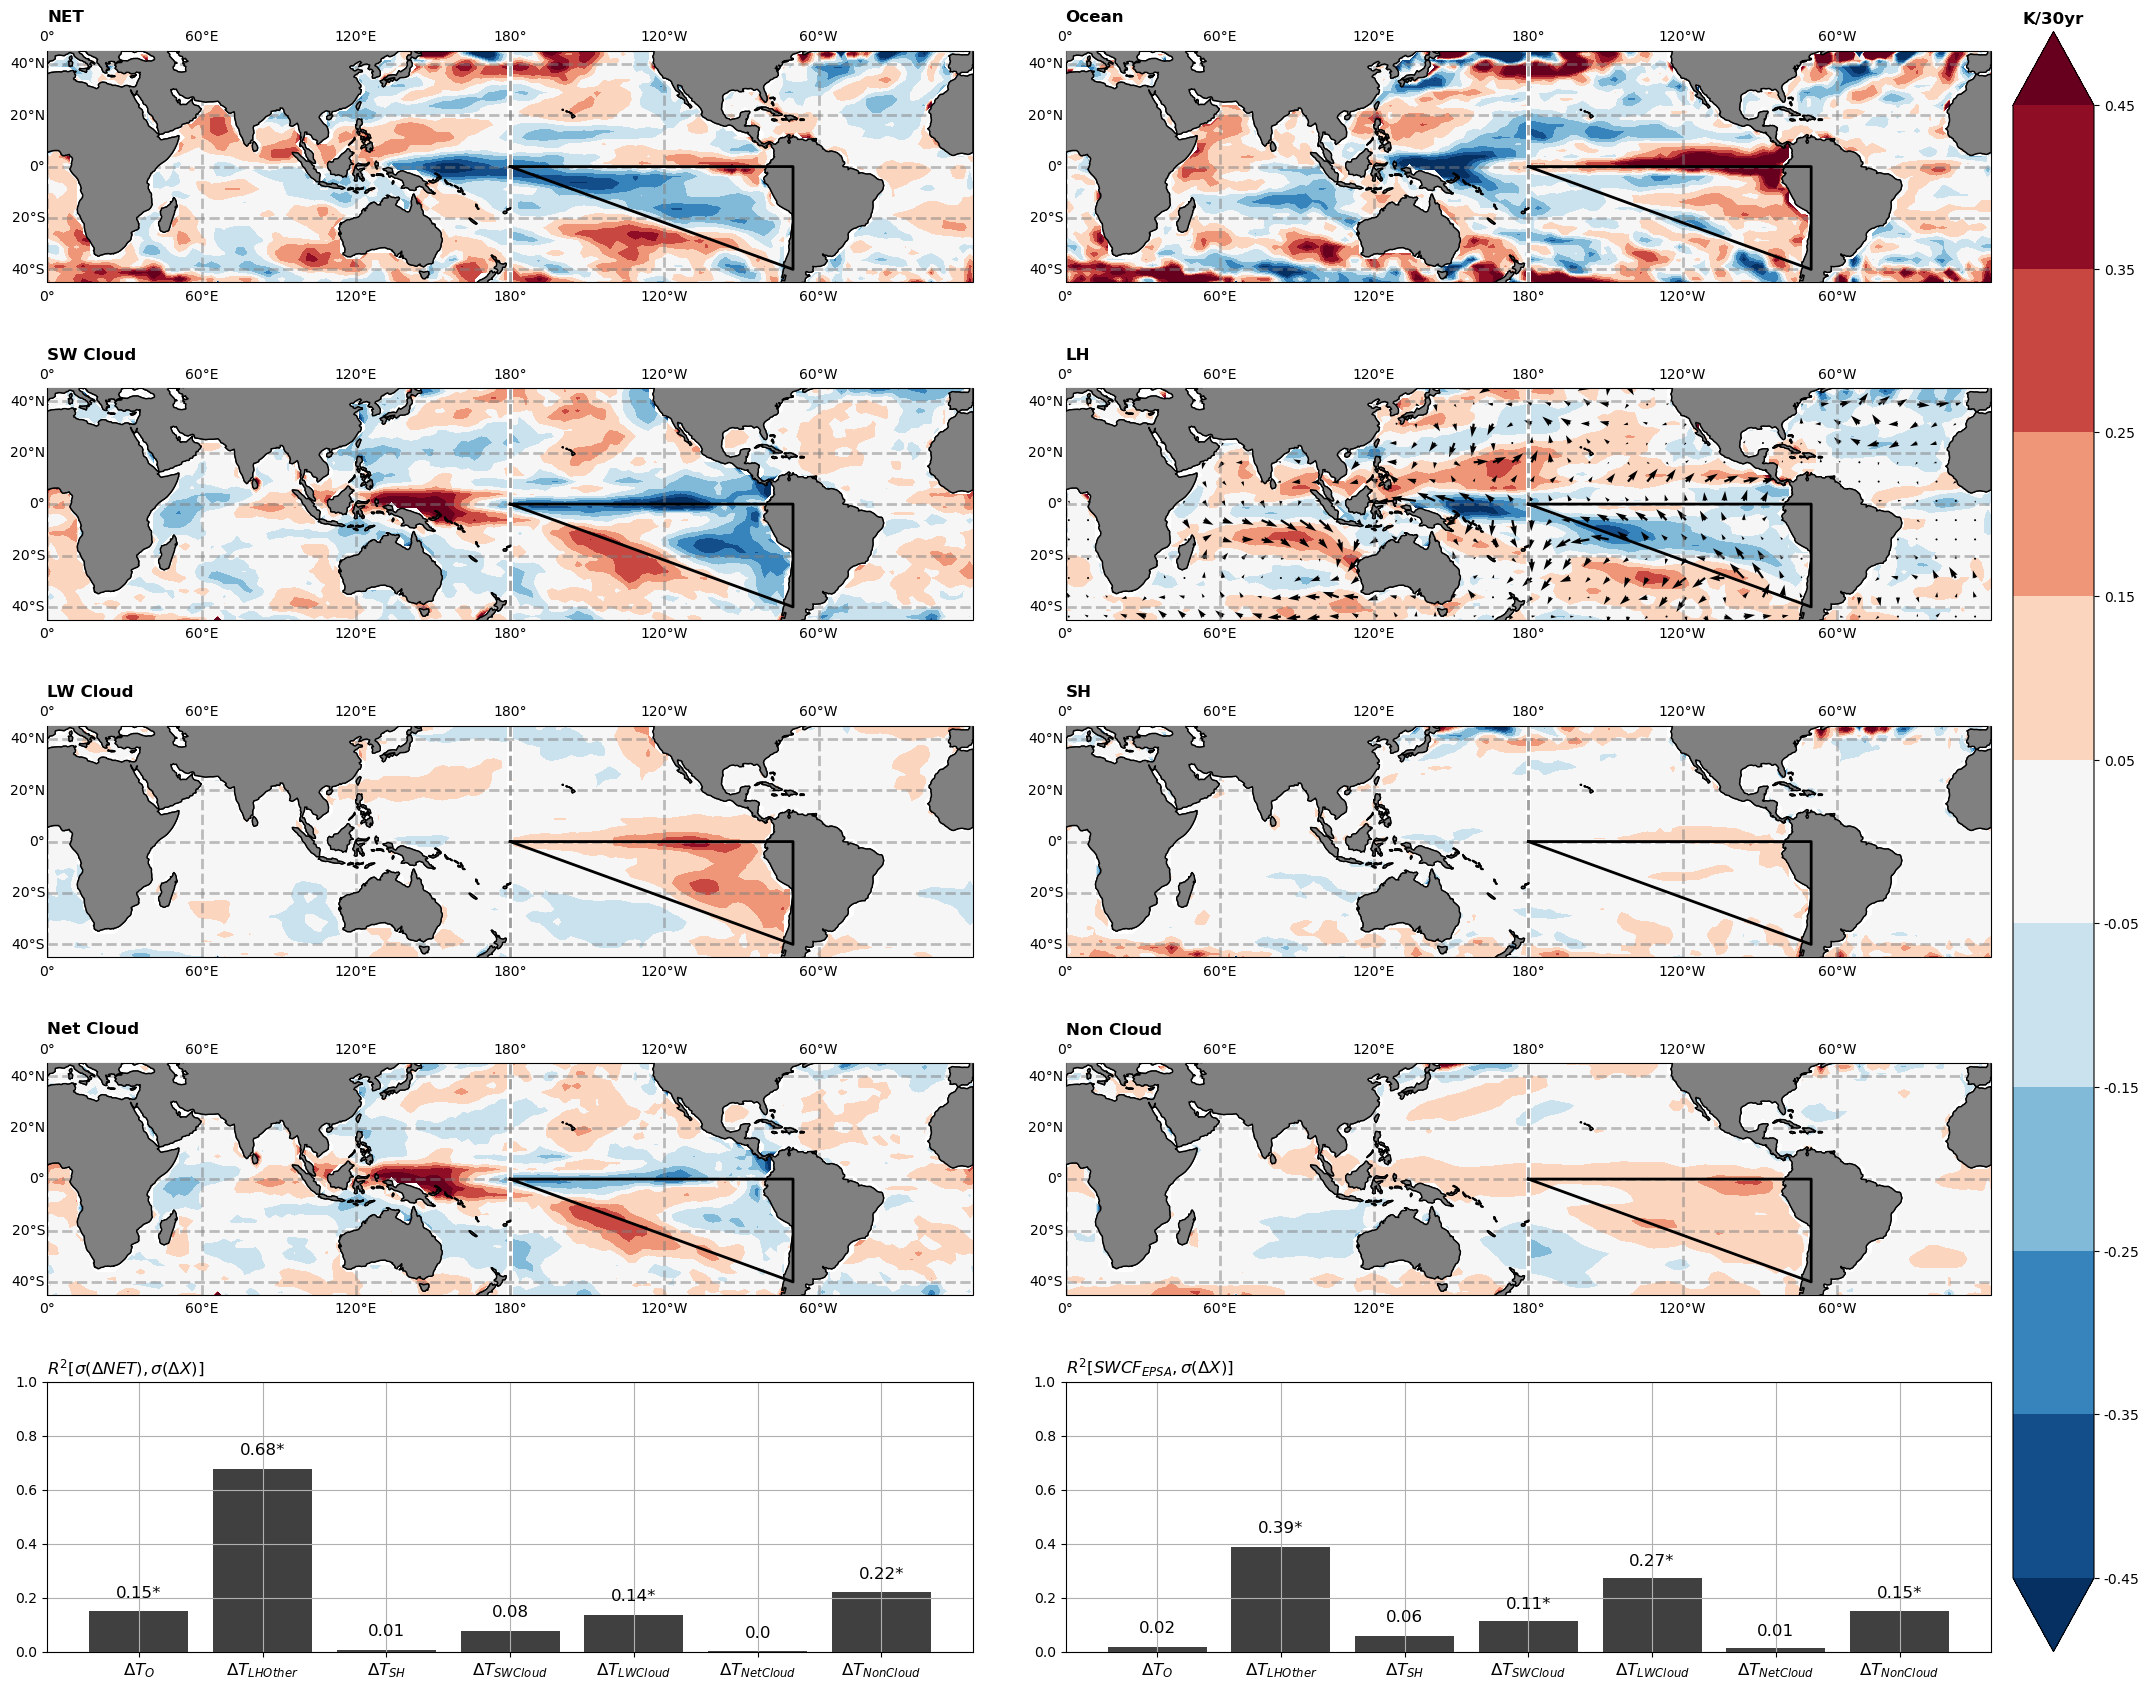

In [23]:
# trend_min, trend_max, trend_step = -0.195, 0.195, 0.03
trend_min, trend_max, trend_step = -0.45, 0.55, 0.1
levels = np.arange(trend_min, trend_max, trend_step)

idx = ["O", "LH_Other", "SH", "SWC", "LWC", "CLOUD", "NON_CLOUD"]
ticklabels = [
    r"$\Delta T_{O}$",
    r"$\Delta T_{LH Other}$", 
    r"$\Delta T_{SH}$", 
    r"$\Delta T_{SW Cloud}$", 
    r"$\Delta T_{LW Cloud}$", 
    r"$\Delta T_{Net Cloud}$",
    r"$\Delta T_{Non Cloud}$",
]

figure_3(
    seb_dif, 
    u=u10_dif,
    v=v10_dif,
    corr_cmip={ticklabels[i]: corr_cmip[key] for i, key in enumerate(idx)},
    p_cmip={ticklabels[i]: p_cmip[key] for i, key in enumerate(idx)},
    levels=levels,
    save_name="Figure_3.png"
)

# Figure S3

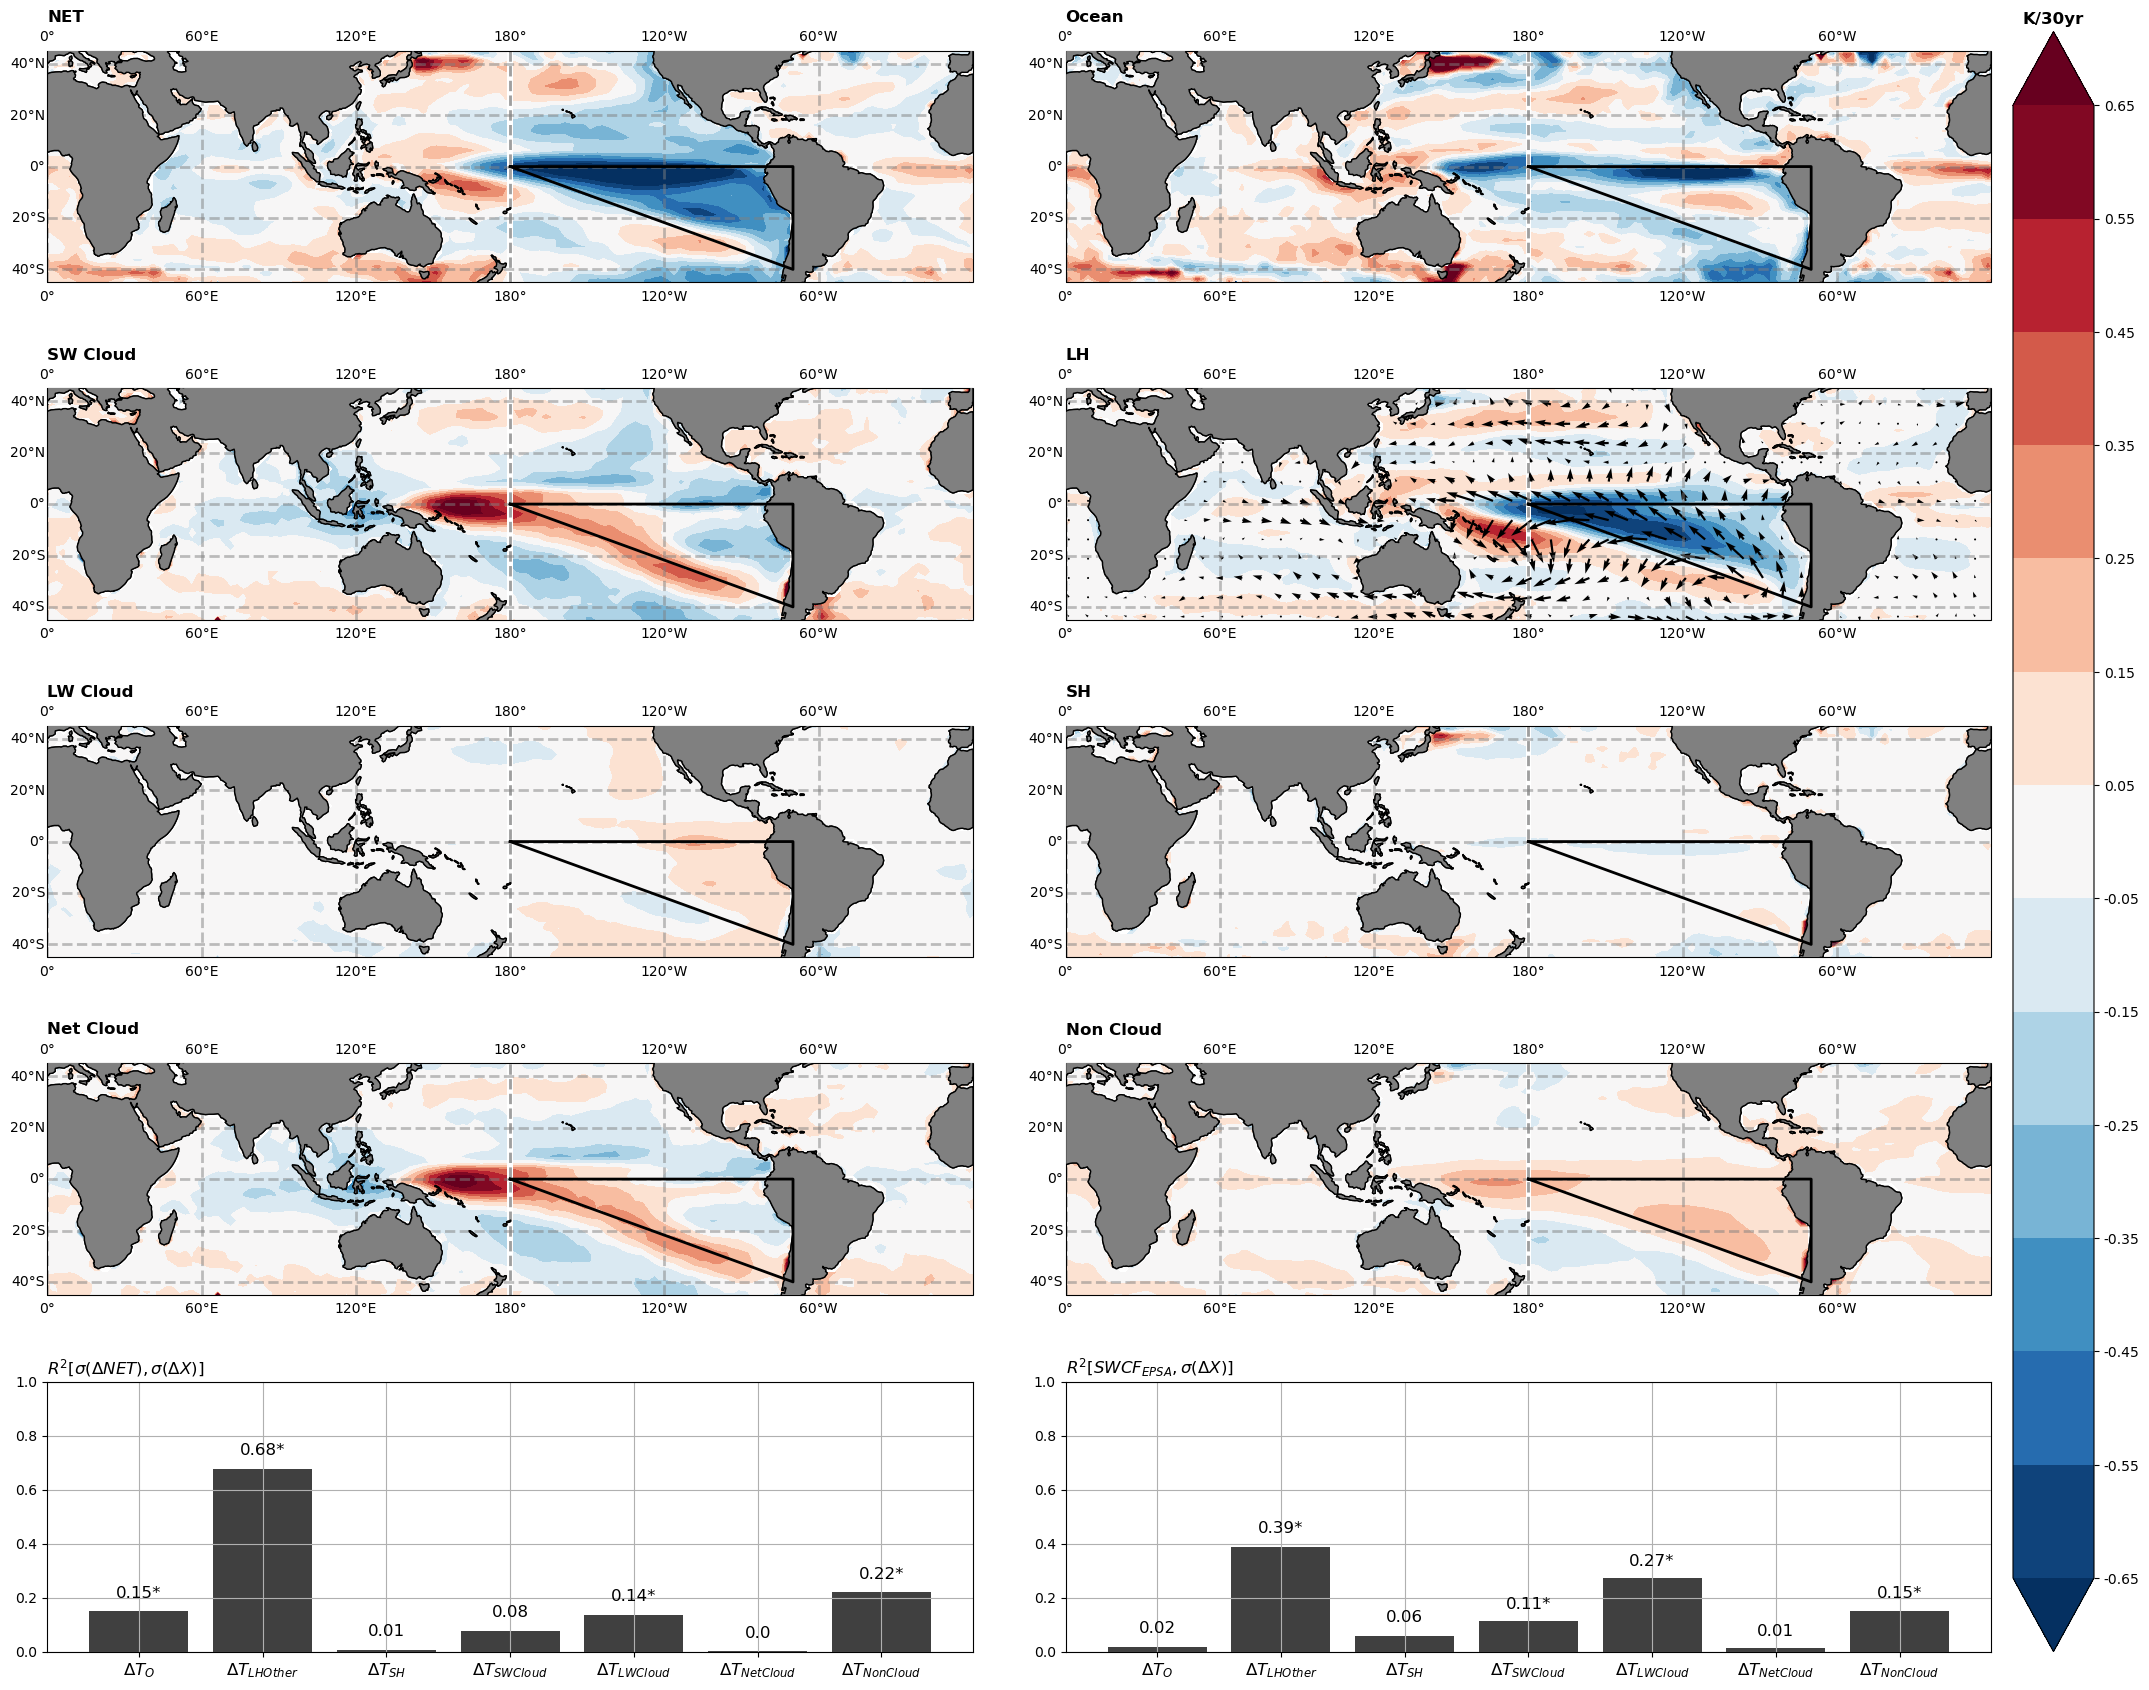

In [24]:
# trend_min, trend_max, trend_step = -0.195, 0.195, 0.03
trend_min, trend_max, trend_step = -0.65, 0.75, 0.1
levels = np.arange(trend_min, trend_max, trend_step)

idx = ["O", "LH_Other", "SH", "SWC", "LWC", "CLOUD", "NON_CLOUD"]
ticklabels = [
    r"$\Delta T_{O}$",
    r"$\Delta T_{LH Other}$", 
    r"$\Delta T_{SH}$", 
    r"$\Delta T_{SW Cloud}$", 
    r"$\Delta T_{LW Cloud}$", 
    r"$\Delta T_{Net Cloud}$",
    r"$\Delta T_{Non Cloud}$",
]

figure_3(
    seb_cmip6=SEB_CMIP6_1sig,
    u=U10_CMIP6_1sig,
    v=V10_CMIP6_1sig,
    corr_cmip={ticklabels[i]: corr_cmip[key] for i, key in enumerate(idx)},
    p_cmip={ticklabels[i]: p_cmip[key] for i, key in enumerate(idx)},
    levels=levels,
    save_name="Figure_S3.png"
)

# Figure 4

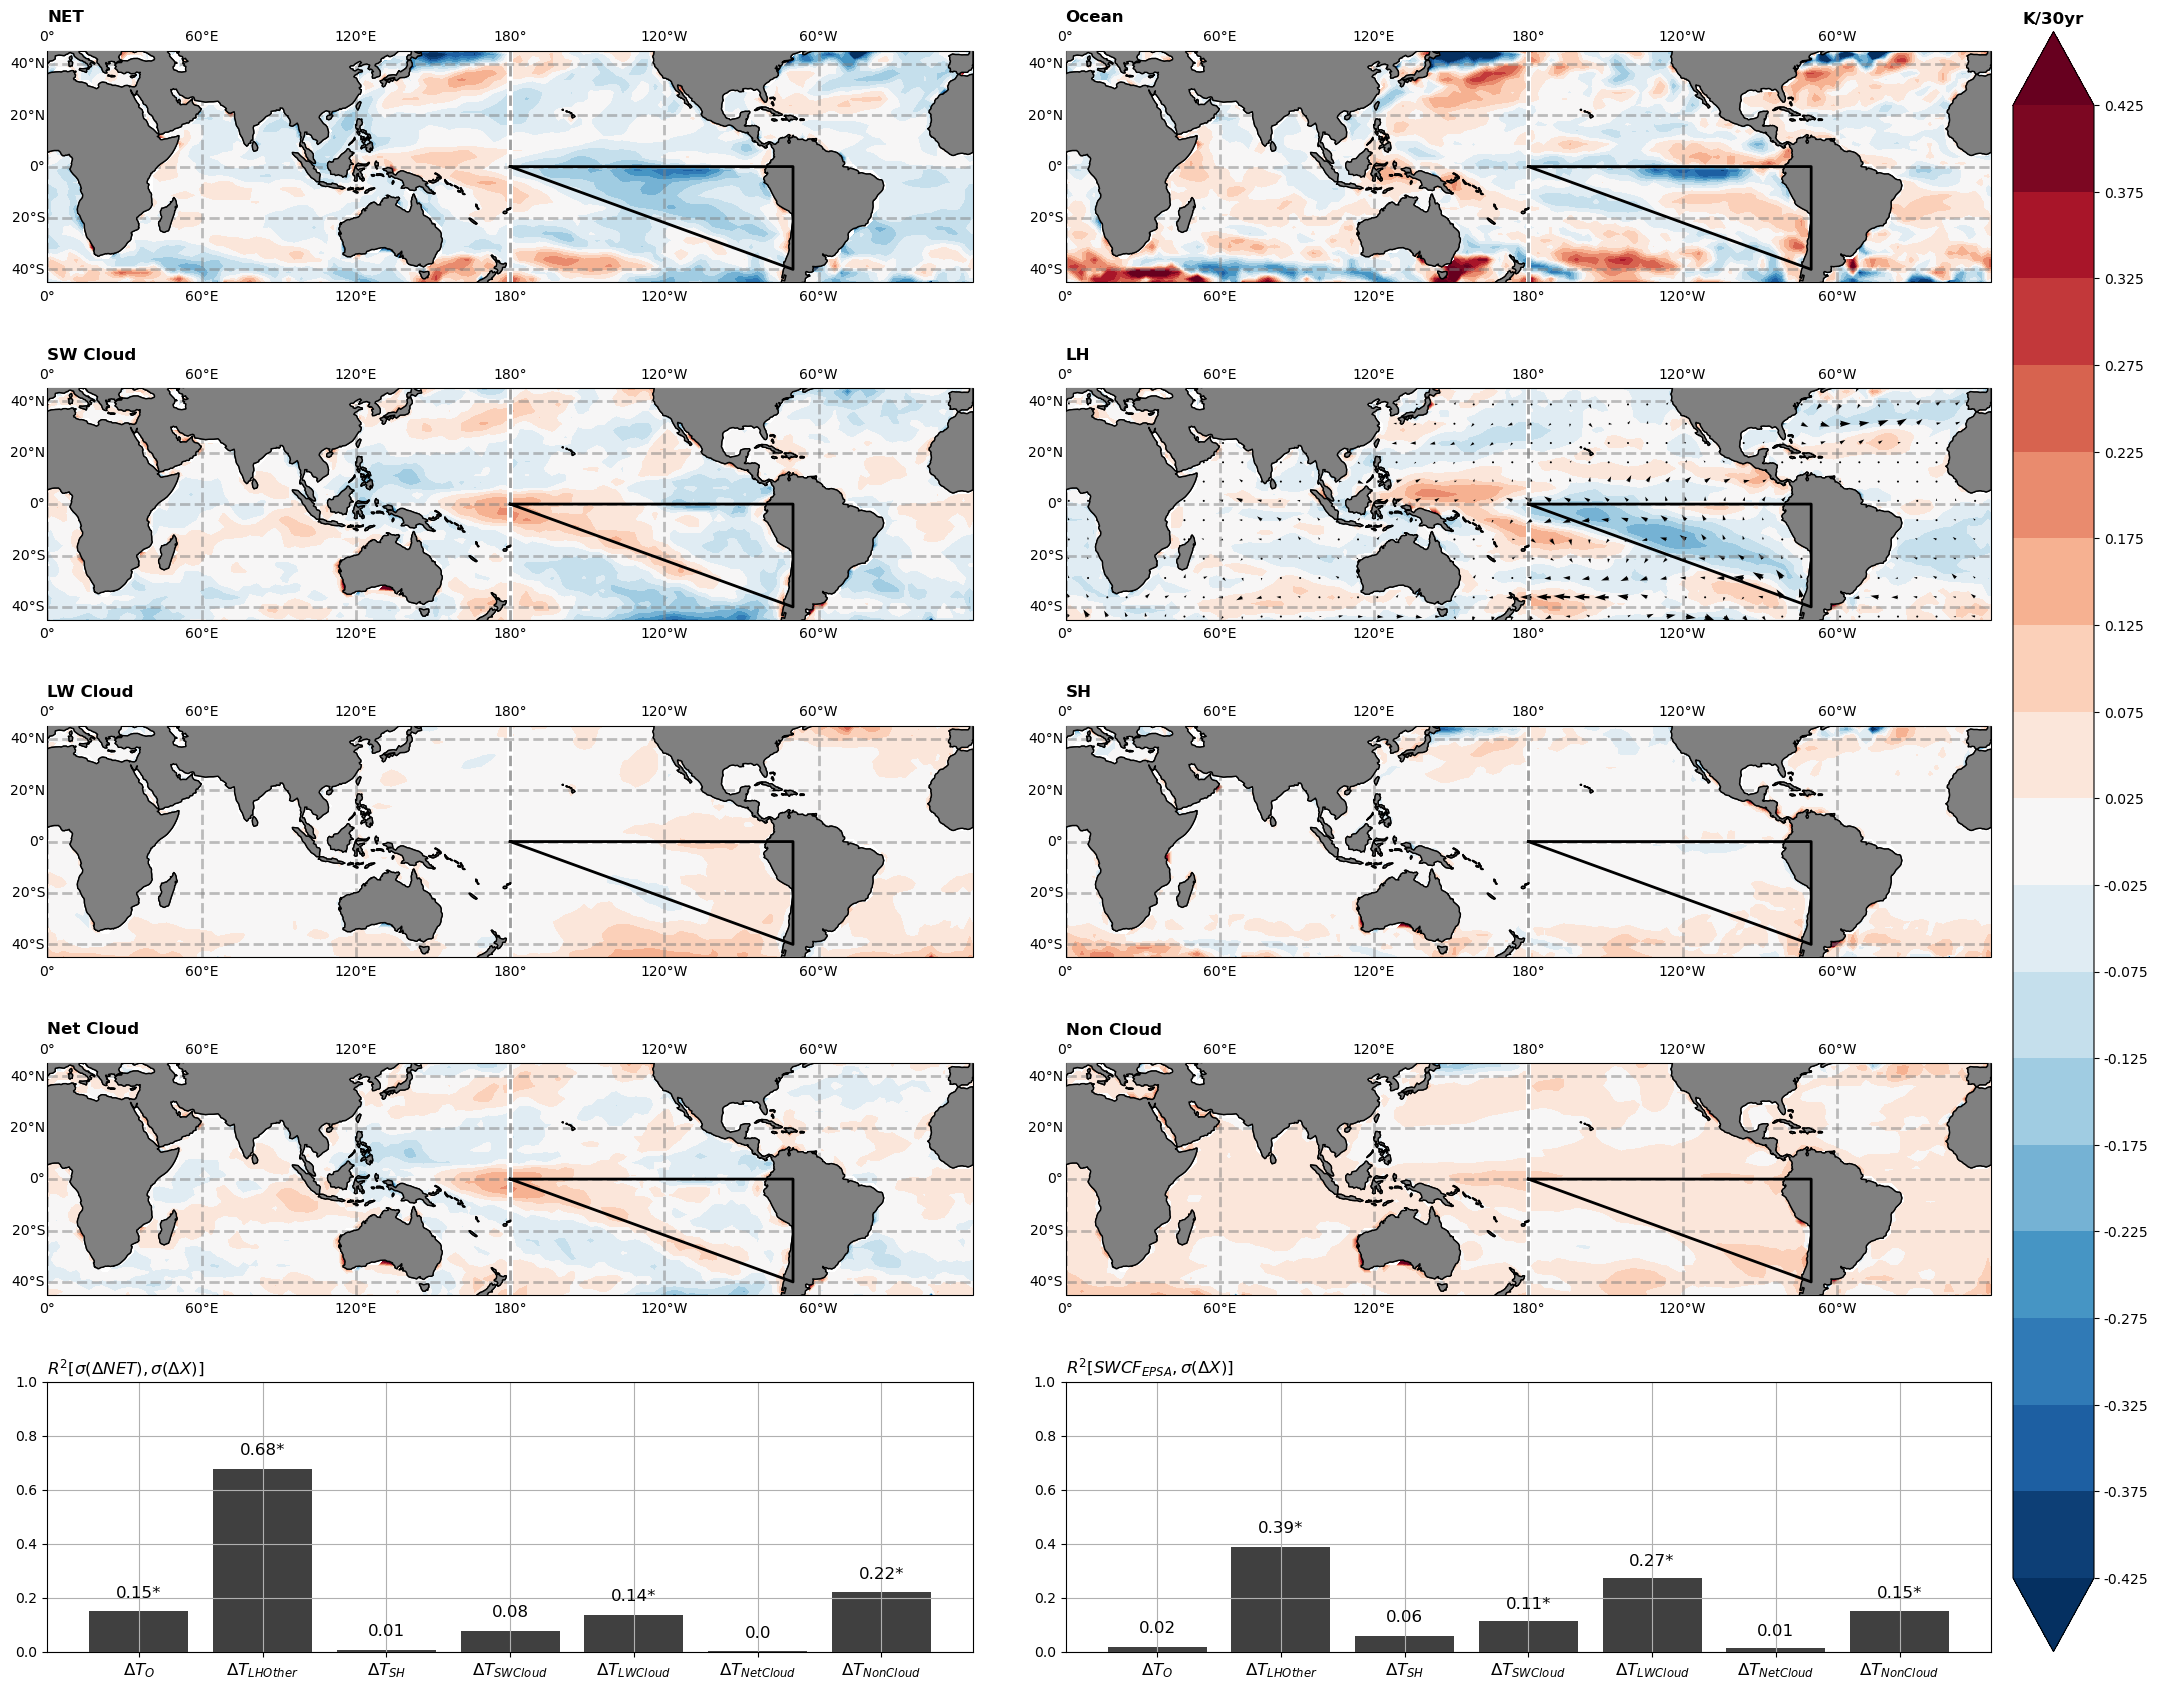

In [27]:
trend_min, trend_max, trend_step = -0.425, 0.430, 0.05
levels = np.arange(trend_min, trend_max, trend_step)

idx = ["O", "LH_Other", "SH", "SWC", "LWC", "CLOUD", "NON_CLOUD"]
ticklabels = [
    r"$\Delta T_{O}$",
    r"$\Delta T_{LH Other}$", 
    r"$\Delta T_{SH}$", 
    r"$\Delta T_{SW Cloud}$", 
    r"$\Delta T_{LW Cloud}$", 
    r"$\Delta T_{Net Cloud}$",
    r"$\Delta T_{Non Cloud}$",
]

figure_3(
    SEB_SO_1sig, 
    u=U10_SO_1sig,
    v=V10_SO_1sig,
    corr_cmip={ticklabels[i]: corr_cmip[key] for i, key in enumerate(idx)},
    p_cmip={ticklabels[i]: p_cmip[key] for i, key in enumerate(idx)},
    levels=levels,
    save_name="Figure_4.png"
)